<a href="https://colab.research.google.com/github/yanglinjing/vmor/blob/master/Copy_of_Copy_of_Bank_customer_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Loan Data

# Step 1： Preparing Data

## Import Libraries

In [1]:
pip install mysql-connector

     |████████████████████████████████| 11.9MB 2.8MB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl size=247949 sha256=1427e029924e2804357ca4fd05565a09be0919ab0f3af1cdbe1146ea014f61f9
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql-connector


In [2]:
# mySQL
import mysql.connector

import numpy as np
import pandas as pd
import datetime as dt


# PCA and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from palettable.colorbrewer.qualitative import Pastel1_7 # color

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
my_color = ['#42bff4', '#f9ace9']

## Import Data

In [0]:
# Import data from mySQL
db = mysql.connector.connect(user='Linjing', 
                             password='Linjing',
                             host='119.9.52.51',
                             database='bankloan')

In [0]:
# Create a Cursor object. It will let
#  you execute all the queries you need
cur = db.cursor()

In [0]:
cur.execute('SELECT * \
             FROM defaultloan')

In [0]:
# Put data into df
table = cur.fetchall()
df_raw = pd.DataFrame(table)

In [0]:
# Get column names 
num_cols = len(cur.description)
cols = [i[0] for i in cur.description]

# Change column names of df
df_raw.columns = cols

In [0]:
db.close()

## Functions

### Basic Bar Chart


In [0]:
# calculate aggregated data

def get_agg_df(col, agg_col, method):
  """
  get aggregating result from df

  INPUT:
    col - the column name in df which data will be grouped by
    agg_col - target column that will be aggregrated
    method - method of aggregration, like "count"

  OUTPUT:
     x - the column that was grouped by
     y - the aggregating result
     result - df with agg results
  """

  # get agg number, return a df
  result = df.groupby(col).agg({agg_col: method})

  # put total number into y
  y = result[agg_col]

  # put index into a new column (index was col)
  result[col] = result.index
  result = result.reset_index(drop = True) # change index to 0,1,2...
  x = result[col]

  return x, y, result

In [0]:
# Plot bar

def draw_basic_bar_plot(x, y, fig_h, fig_w, title, x_lab, y_lab):
  """
  Draw a basic bar plot

  INPUTS:
     x - the column that was grouped by
     y - the aggregating result
     fig_h, fig_w - size of the figure
     title - plot title
     x_lab, y_lab - x and y lable
  """

  # Import data:
  height = y
  bars = x
  y_pos = np.arange(len(bars))

  # Change the shape of figure
  fig = plt.figure(num=None, figsize=(fig_h, fig_w), dpi=80, facecolor='w', edgecolor='k')

  # Create bars
  plt.bar(y_pos, height, color = my_color[0])
  
  # Create names on the x-axis
  plt.xticks(y_pos, bars, rotation=60)

  # Add title and labels
  fig.suptitle(title, fontsize = 20)
  plt.xlabel(x_lab, fontsize = 18)
  plt.ylabel(y_lab, fontsize = 16)

  # Show graphic
  plt.show()

### Different Pie Chart


In [0]:
# calculate data

def count_types(col):
  # calculate the number of product types
  new_df = df[col].value_counts()

  # put the value_counts() output into df
  new_df = new_df.rename_axis('type').reset_index(name='counts')

  # use column as index
  new_df.set_index('type', inplace=True)

  return new_df

In [0]:
def plot_pct(df):
  df.plot(kind='pie', subplots=True, figsize=(16,8))

In [0]:
def plot_pie(category_df):
  labels = category_df.index.to_list()
  values = category_df['counts'].to_list()

  fig1, ax1 = plt.subplots()
  ax1.pie(values, labels=labels, 
          colors=Pastel1_7.hex_colors, 
          autopct='%1.1f%%', 
          shadow=True, startangle=90)
  
  # Equal aspect ratio ensures that pie is drawn as a circle
  ax1.axis('equal')
  plt.tight_layout()
  plt.show()

In [0]:
def plot_donut(amt_df):
  labels = amt_df.index.to_list()
  values = amt_df['counts'].to_list()

  # Create a circle for the center of the plot
  my_circle=plt.Circle( (0,0), 0.7, color='white')

  #explsion
  explode = []

  for i in range(len(values)):
    explode.append(0.05)

  # draw the plot
  plt.pie(values, labels=labels, 
          colors = Pastel1_7.hex_colors, 
          autopct='%1.1f%%', # show percentage
          startangle=90, 
          pctdistance=0.85, explode = explode)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


# Step 2: Proprecessing Data


## Step 2.1 Observing Data

In [0]:
df = df_raw.copy()

In [17]:
df.shape

(276546, 50)

## Step 2.2 Convert Data Type

In [0]:
# convert object to datetime

column_date = ['Application_Date', 
               'Entry_Date', 
               'Fist Installment Date', 
               'Expected Contract End Date', 
               'DefaultDate', 
               'Recent Default_Default Date',
               #'Recent Default_Cure Date',
               'Consumer Year of Birth']

for column in column_date:
  df[column] = pd.to_datetime(df[column])

In [0]:
# convert object to float

column_num = ['Purchase Amt', 'Deposit Amt', 'Financed Amt', 
              'Total Term', 'Deposit_Percent', 'Term_Run',
              'Term_Remaining', 'Total No Of Payments',
              'Instalment Amt', 'Total Payments Received',
              'Total Balance Outstanding', 'Amt Paid To Merchant_nettofmerchfeesandGST',
              'Gtee Rate', 'Gtee Charges', 'Est Fees',
              'Proc Fees', 'Other Fees', 'Total Merchant Charges',
              'Total Consumer Charges', 'Total Charges',
              'Effective Billing Rate', 'No Of Days In Default',
              'Arrears Amount', 'No of Days in Arrears',
              'DefaultAmount', 'MonthsToDefault',
              'Recent Default_Default Amt',
              'Recent Default_Recov Amt']

for column in column_num:

  # Remove thousand separator 
  df[column] = df[column].str.replace(',', '')

  # Nan / NaT
  df[column] = df[column].str.replace('NaT', '')
  df[column] = df[column].str.replace('NaN', '')

  # convert string to numeric
  df[column] = pd.to_numeric(df[column])


## Step 2.3 Missing Values

### Step 2.3.1 Columns


In [20]:
# Calculate the percentage of missing values of each column
missing = df.isnull().sum()
missing = missing[missing > 0] / df.shape[0] *100
missing.sort_values(inplace = True)

print(f"{len(missing)} out of {df.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")

7 out of 50 columns contain missing values, from 0.0% to 95.97%.


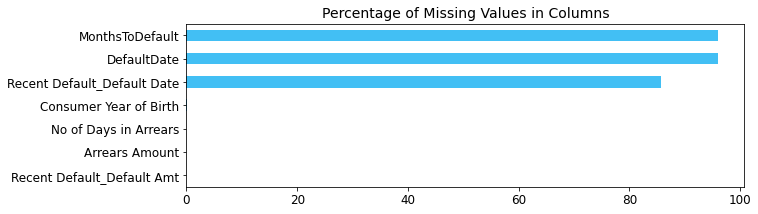

In [21]:
#Visualizing the naturally missing data
missing.plot.barh(figsize = (10, 3), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

In [0]:
# Remove the outlier columns from the dataset / feature summary. 

# columns have more than 80% missing values
missing_80 = missing[missing >80]

# Drop columns that contain 20% missing values
for col in missing_80.index:
  
  # Dataset
  df.drop(col, axis = 1, inplace = True)


In [23]:
df.shape

(276546, 47)

### Step 2.3.2 Rows


In [0]:
# How much data is missing in each row of the dataset?
missing_r = df.isnull().sum(axis=1)

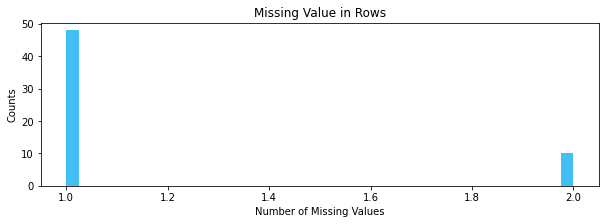

In [25]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', bins=40, figsize=(10,3), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

## Step 2.4 Calculate Percentage

In [0]:
# arrears and all kinds of fees
fees = ['Arrears Amount',
        'DefaultAmount',
        'Recent Default_Default Amt',
        'Recent Default_Recov Amt',
        'Amt Paid To Merchant_nettofmerchfeesandGST',
        'Est Fees',
        'Proc Fees',
        'Other Fees',
        'Total Merchant Charges',
        'Total Consumer Charges'
        ]

In [0]:
fees = ['Arrears Amount',
        'DefaultAmount',
        'Recent Default_Default Amt',
        'Recent Default_Recov Amt',
        'Amt Paid To Merchant_nettofmerchfeesandGST',
        'Est Fees',
        'Proc Fees',
        'Other Fees',
        'Total Merchant Charges',
        'Total Consumer Charges'
        ]

In [28]:
df.sample(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Total Term,Deposit_Percent,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
106909,137981,60992692,L60992692,BEDDING,PaidInFull,2006-10-26,2006-11-13,2006H2,2006-07-12,4836.0,1209.0,3627.0,24,0.25,24,0,Bank,24,Mth,151.125,3627.0,0.0,3128.1,0.114,413.47,40.0,0,0.0,453.47,0.0,453.47,0.125026,2008-07-12,0,0.0,0.0,0.0,1964.68,302.24,39430,4271,1949-02-26,30106666,WENATEX AUSTRALIA PTY LTD,Furniture / Bedding New,No,No


In [0]:
# convert amount to percentage
for fee in fees:
  df[fee] = df[fee] / df['Financed Amt']

In [0]:
# rename columns (amount -> percentage)
df.rename(columns={'Arrears Amount': 'arrear_p',
                   'DefaultAmount': 'default_p',
                    'Recent Default_Default Amt': 'recent_default_default_p',
                    'Recent Default_Recov Amt': 'recent_default_recov_p',
                    'Amt Paid To Merchant_nettofmerchfeesandGST': 'gst_p',
                    'Est Fees': 'est_fee_p',
                    'Other Fees': 'other_fee_p',
                    'Total Merchant Charges': 'total_merchant_charge_p',
                    'Total Consumer Charges': 'total_consumer_charges'                
                   }, 
          inplace=True)

## Step 2.5 Rename Columns

In [0]:
df.rename(columns={'Financed Amt': 'financed_amt', 
                   'Deposit_Percent': 'deposit_percent',
                   'Payment Type': 'payment_type',
                   'Instalment Amt': 'instalment_amt',
                   'Gtee Rate': 'gtee_p',
                   'Effective Billing Rate': 'effective_billing_rate',
                   'No Of Days In Default': 'days_default',
                   'No Of Days In Arrears': 'days_arrears',
                   'MonthsToDefault': 'mth_to_default'              
                   }, 
          inplace=True)

## Step 2.6 Re-Encode Non-Numeric Binary Variable

Re-encode: 2-level obj

`Freq`

* FN: Fortnightly: 0
* Mth: Monthly: 1

`payment_type`

* Bank: 0
* CC: 1

`Homowner Ind`, `Homowner Consumer`
* Yes: 1
* No: 0

In [0]:
# Re-encode: 2-level obj
df['Freq'] = df['Freq'].map({'FN': 0, 'Mth': 1})
df['payment_type'] = df['payment_type'].map({'Bank': 0, 'CC': 1})
df['Homowner Ind'] = df['Homowner Ind'].map({'Yes':1, 'No':0})
df['Homowner Consumer'] = df['Homowner Consumer'].map({'Yes':1, 'No':0})

In [33]:
df.sample(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
16876,16877,60601756,L60601756,RINC,PaidInFull,2006-03-24,2006-03-04,2006H1,2006-04-21,1395.0,348.75,1046.25,12,0.250000,12,0,0,26,0,40.234195,1046.25,0.0,0.886213,0.0928,82.15,0.020072,0.0,0.004779,0.103369,0.0,108.15,0.103369,2007-04-21,0,0.0,0.0,0.0,0.0,0.0,,2800,1959-06-11,30102129,REGENCY JEWELLERS - ORANGE,Jewellery,0,0
242996,305138,61228994,L60218466,GOODS,PaidInFull,2007-12-13,2007-12-26,2007H2,2008-10-01,1995.0,1000.00,995.00,12,0.501253,12,0,1,26,0,38.263344,995.00,0.0,0.878894,0.0849,84.47,0.025126,0.0,0.000000,0.110020,0.0,109.47,0.110020,2009-10-01,0,0.0,0.0,0.0,0.0,0.0,,2680,1967-12-23,30111272,MICHAEL HILL JEWELLER WAGGA WAGGA (279),Jewellery,0,0
34473,34474,60769072,L60769072,6120096,PaidInFull,2006-10-28,2006-08-12,2006H2,2006-12-28,550.0,138.00,412.00,12,0.250909,12,0,0,12,1,34.333333,412.00,0.0,0.838350,0.0910,37.49,0.055825,0.0,0.000000,0.146820,0.0,60.49,0.146820,2007-12-28,0,0.0,0.0,0.0,0.0,0.0,,7253,1958-01-20,30110720,PROUDS JEWELLERS LAUNCESTON (105),Jewellery,0,0


## Step 2.7 Categorical Variable with more than 2 types

Some of 'PaidInFull' and 'Active' consumers also have arrears.


In [34]:
df['Contract_Status'].value_counts()

PaidInFull    264847
Default        11178
Active           521
Name: Contract_Status, dtype: int64

In [35]:
df[(df['Contract_Status']=='PaidInFull') & (df['recent_default_default_p']>0)]

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer
15,16,30000086,L30000086,ALARM,PaidInFull,2006-11-10,2006-10-25,2006H2,2006-11-30,3172.38,572.38,2600.00,48,0.180426,48,0,0,48,1,54.166667,2600.00,0.0,0.755885,0.2219,576.93,0.000000,0.0,0.000000,0.221896,0.011538,606.93,0.233435,2010-11-30,0,0.0,0.0,0.0,0.750031,0.032369,39458,6065,1984-02-13,30112641,MODERN SECURITY WA,Home Security,1,1
18,19,30000090,L30000090,ALARM,PaidInFull,2006-10-21,2006-07-12,2006H2,2006-12-17,3672.38,1072.38,2600.00,48,0.292012,48,0,1,48,1,54.166667,2600.00,0.0,0.755885,0.2219,576.93,0.000000,0.0,0.000000,0.221896,0.000000,576.93,0.221896,2010-12-17,0,0.0,0.0,0.0,0.708369,0.020831,39505,6063,1964-02-16,30112641,MODERN SECURITY WA,Home Security,1,1
33,34,30000554,L30000554,ALARM,PaidInFull,2006-10-11,2006-03-12,2006H2,2006-12-25,2671.38,271.38,2400.00,48,0.101588,48,0,0,48,1,50.000000,2400.00,0.0,0.755875,0.2219,532.55,0.000000,0.0,0.000000,0.221896,0.000000,532.55,0.221896,2010-12-25,0,0.0,0.0,0.0,0.020833,0.020833,40521,2795,1924-03-12,30112646,MODERN SECURITY NSW,Home Security,1,1
51,52,30000804,L74001920,ALARM,PaidInFull,2006-01-11,2006-08-11,2006H2,2006-11-18,2860.38,290.38,2570.00,48,0.101518,48,0,0,48,1,53.541667,2570.00,0.0,0.755875,0.2219,570.28,0.000000,0.0,0.000000,0.221899,0.007082,588.48,0.228981,2010-11-18,0,0.0,0.0,0.0,0.277938,0.041665,40182,6107,1966-11-12,30112641,MODERN SECURITY WA,Home Security,1,1
58,59,30000875,L30000875,ALARM,PaidInFull,2006-10-31,2006-08-11,2006H2,2006-11-16,3322.38,722.38,2600.00,48,0.217428,48,0,0,48,1,54.166667,2600.00,0.0,0.755885,0.2219,576.93,0.000000,0.0,0.000000,0.221896,0.023077,636.93,0.244973,2010-11-16,0,0.0,0.0,0.0,0.032492,0.032492,40521,6112,1969-03-26,30112641,MODERN SECURITY WA,Home Security,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276509,338651,99675744,L99675744,REPAIRS,PaidInFull,2007-06-12,2007-12-19,2007H2,2008-07-01,2335.27,835.27,1500.00,6,0.357676,6,0,0,13,0,115.366867,1500.00,0.0,0.897133,0.0740,110.99,0.006500,0.0,0.013000,0.093493,0.040000,200.24,0.133493,2008-07-07,0,0.0,0.0,0.0,0.076960,0.076960,39654,6169,1972-11-27,30100724,LUBE MOBILE PERTH,Auto Repair / Service,0,0
276520,338662,99676938,L99676938,REPAIRS,PaidInFull,2007-11-12,2007-12-19,2007H2,2007-12-25,1141.74,300.00,841.74,6,0.262757,6,0,0,6,1,140.290000,841.74,0.0,0.894100,0.0740,62.28,0.011583,0.0,0.010692,0.096265,0.047521,121.03,0.143785,2008-06-25,0,0.0,0.0,0.0,0.833345,0.368974,39546,6059,1987-02-24,30100724,LUBE MOBILE PERTH,Auto Repair / Service,0,0
276529,338671,99677866,L99677866,REPAIRS,PaidInFull,2007-04-24,2007-08-05,2007H1,2007-05-24,990.00,247.50,742.50,6,0.250000,6,0,1,6,1,123.750000,742.50,0.0,0.891448,0.0734,54.49,0.013131,0.0,0.012121,0.098640,0.000000,73.24,0.098640,2007-11-24,0,0.0,0.0,0.0,0.250061,0.250061,39458,3004,1973-07-22,30100721,LUBE MOBILE - THORNBURY,Auto Repair / Service,0,0
276532,338674,99678153,L99678153,REPAIRZ,PaidInFull,2007-12-12,2007-12-23,2007H2,2008-04-01,1063.14,290.00,773.14,6,0.272777,6,0,1,6,1,128.856667,773.14,0.0,0.891818,0.0740,57.21,0.012611,0.0,0.011641,0.098249,0.090540,145.96,0.188789,2008-04-07,0,0.0,0.0,0.0,0.833342,0.833342,39605,2763,1964-09-28,30100720,LUB

## Step 2.8 Mark people who have had arrears

Is there anyone who have never had arrears?

In [36]:
# Is there anyone who does not have arrears?

df_no_arrears = df[df['recent_default_default_p'] == 0]

no_arrear_p = df_no_arrears.shape[0] / df.shape[0] * 100

print(f"{df_no_arrears.shape[0]} people do not have arrears, occupying {round(no_arrear_p, 2)}%.")

237019 people do not have arrears, occupying 85.71%.


In [0]:
df['has_arrears'] = df['recent_default_default_p'].apply(lambda x: 1 if x > 0 else 0)

How many people have had arrears?

In [38]:
# How many people have had arrears?

df_has_arrears = df[df['recent_default_default_p'] > 0]

has_arrear_p = df_has_arrears.shape[0] / df.shape[0] * 100

print(f"{df_has_arrears.shape[0]} people have had arrears, occupying {round(has_arrear_p, 2)}%.")

39526 people have had arrears, occupying 14.29%.


How many people have recovered arrears?

In [39]:
# How many people have recovered arrears?

df_recov = df[df['recent_default_recov_p'] > 0]

recov_p = df_recov.shape[0] / df.shape[0] * 100

recov_p_2 = df_recov.shape[0] / df_has_arrears.shape[0] * 100

print(f'{df_recov.shape[0]} people have recovered arrears, \
 occupying {round(recov_p, 2)}% of the population \
 and {round(recov_p_2, 2)}% of the people with arrears.')

32146 people have recovered arrears,  occupying 11.62% of the population  and 81.33% of the people with arrears.


In [40]:
print(f'{df_has_arrears.shape[0] - df_recov.shape[0]} people have had arrears but never recovered.')

7380 people have had arrears but never recovered.


How many people have recovered arrears in full?

In [41]:
# How many people have recovered arrears in full?

df_recov_infull = df[df['recent_default_recov_p']==1]

recov_infull_p = df_recov_infull.shape[0] / df.shape[0] * 100

recov_infull_p_2 = df_recov_infull.shape[0] / df_has_arrears.shape[0] * 100

print(f'{df_recov_infull.shape[0]} people have recovered arrears in full,\
 occupying {round(recov_infull_p, 2)}% of the population \
 and {round(recov_infull_p_2, 2)}% of the people with arrears.')

700 people have recovered arrears in full, occupying 0.25% of the population  and 1.77% of the people with arrears.


## 2.10 Age

In [0]:
# Calculate Age: days / 365

df['age'] = df['Application_Date'] - df['Consumer Year of Birth']
df['age'] = df['age'].apply(lambda x: x.days / 365)

## 2.9 Product column

## 2.9.1 contains empty values

In [0]:
# replace empty string with NAN
df['Product'] = df['Product'].replace(r'^\s*$', np.NaN, regex=True)

In [44]:
df['Product'].isnull().sum()

13747

## 2.9.2 similar values

In [0]:
df['Product'].replace('RINGS','RING', inplace = True)
df['Product'].replace(['JEWELLE', 'JEWELLY', 'BRACELE', 'BANGLE'], 'JEWELRY', inplace = True)
df['Product'].replace(['FURNITU', 'FURNITR', 'FURN'], 'FURNITURE', inplace = True)
df['Product'].replace('VAC', 'VACUUM', inplace = True)


In [0]:
df_cleaned = df.copy()

# Step 3 Exploring Data

## 3.1 Contracts

* How many contracts in total? For each year? For month? - (bar chart)

In [47]:
print(f"The totla number of contracts is {df.shape[0]:,}.")

The totla number of contracts is 276,546.


In [48]:
print(f"The earlist entry date is {df['Entry_Date'].min()}, whereas the latest is {df['Entry_Date'].max()}.")

The earlist entry date is 2006-01-01 00:00:00, whereas the latest is 2007-12-31 00:00:00.


In [0]:
# put Year into new columns
df['entry_y'] = df['Entry_Date'].dt.year
#df['entry_m'] = df['Entry_Date'].dt.month

# put Year and Month into new columns
df['entry_y_m'] = df['Entry_Date'].dt.to_period('M')

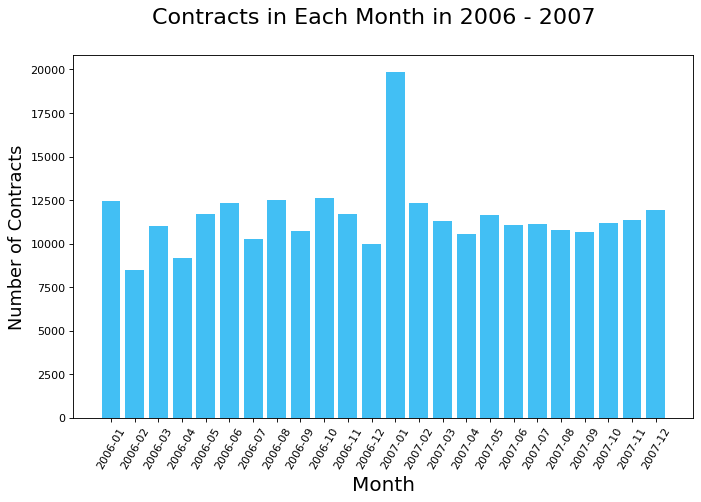

In [50]:
x, y, r = get_agg_df('entry_y_m', 'Contract_Number', "count")
draw_basic_bar_plot(x, y, 10, 6, 'Contracts in Each Month in 2006 - 2007', 'Month', 'Number of Contracts')

In [51]:
x, y, r = get_agg_df('entry_y', 'Contract_Number', "count")
r

,Contract_Number,entry_y
0,132791,2006
1,143755,2007


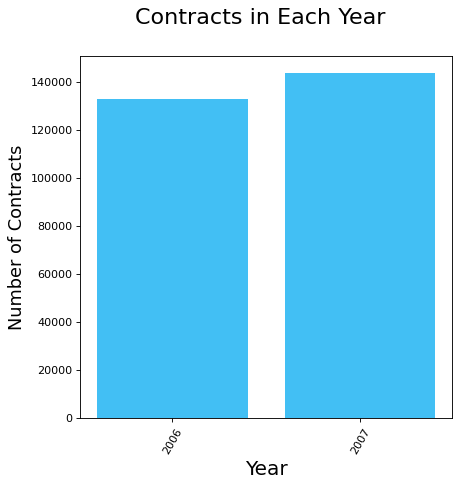

In [52]:
draw_basic_bar_plot(x, y, 6, 6, 'Contracts in Each Year', 'Year', 'Number of Contracts')

## 3.2 Consumers

 

### 3.2.1 How many consumers in total?

In [53]:
df['Consumer_ID'].value_counts()

L61112156    10
L50019007     7
L50016784     7
L60832218     7
L60028728     7
             ..
L80767091     1
L61057940     1
L60999835     1
L61240720     1
L61217938     1
Name: Consumer_ID, Length: 255718, dtype: int64

### 3.2.2 How about the increased rate/number of consumers for each year? For month?

In [54]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,has_arrears,age,entry_y,entry_y_m
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,0.755885,0.2219,576.93,0.0,0.0,0.0,0.221896,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,0,45.928767,2006,2006-01


In [0]:
# put Year into new columns
df['app_y'] = df['Application_Date'].dt.year

# put Year and Month into new columns
df['app_y_m'] = df['Application_Date'].dt.to_period('M')

In [56]:
x, y, r = get_agg_df('app_y', 'Consumer_ID', 'count')
r

,Consumer_ID,app_y
0,1,2004
1,8738,2005
2,133882,2006
3,133925,2007


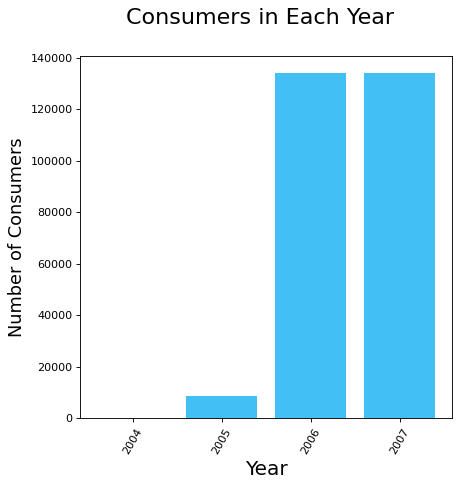

In [57]:
draw_basic_bar_plot(x, y, 6, 6, 'Consumers in Each Year', 'Year', 'Number of Consumers')

In [0]:
x, y, r = get_agg_df('app_y_m', 'Consumer_ID', 'count')

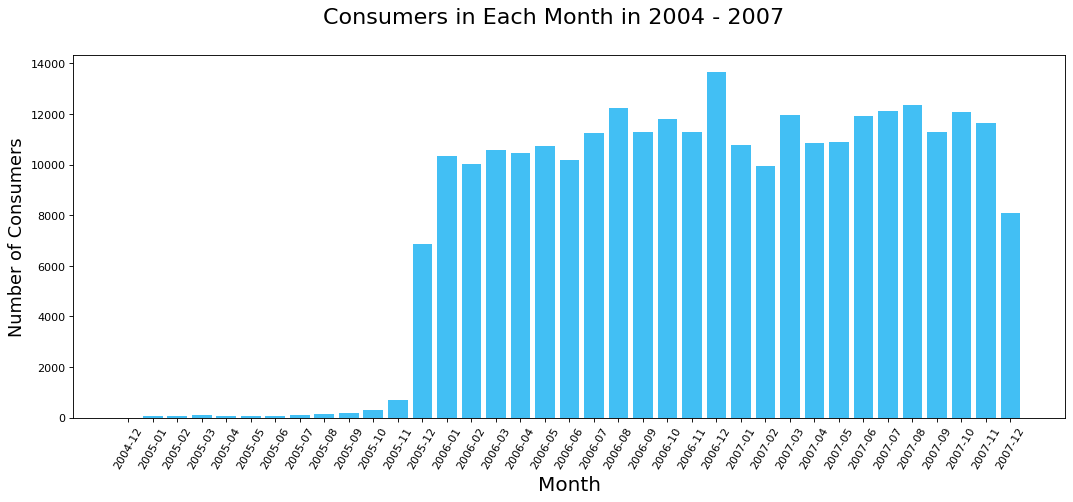

In [59]:
draw_basic_bar_plot(x, y, 16, 6, 'Consumers in Each Month in 2004 - 2007', 'Month', 'Number of Consumers')

In [0]:
# calculate the increased rate of each month
r['consumer_increased_rate'] = r['Consumer_ID'].pct_change()

In [0]:
r.drop(r.index[[0,1]], inplace=True)

## 3.3 Products

How many products in total? What are the percentages for each product?


In [0]:
product_df = count_types('Product')

In [63]:
print(f"There are {product_df.shape[0]:,} kinds of products, \
and {product_df[product_df['counts'] >1000].shape[0]} types \
of them were bought more than 1000 times.")

There are 22,723 kinds of products, and 28 types of them were bought more than 1000 times.


In [0]:
# build a new df, with types more than 1000
product_df_new = product_df[product_df['counts'] > 1000]


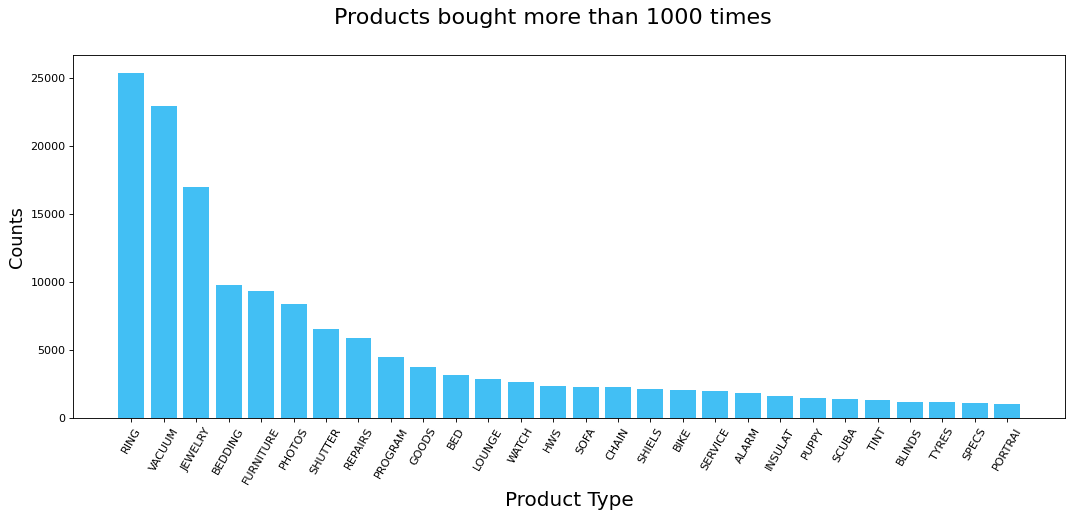

In [65]:
draw_basic_bar_plot(
    product_df_new.index.to_list(),
    product_df_new['counts'].to_list(),
    16, 6,
    "Products bought more than 1000 times", "Product Type", "Counts"
)

## 3.4 Contracts

How many types of Contract_status? What are the percentages for every status? (pie chart)

In [0]:
contract_status_df = count_types('Contract_Status')

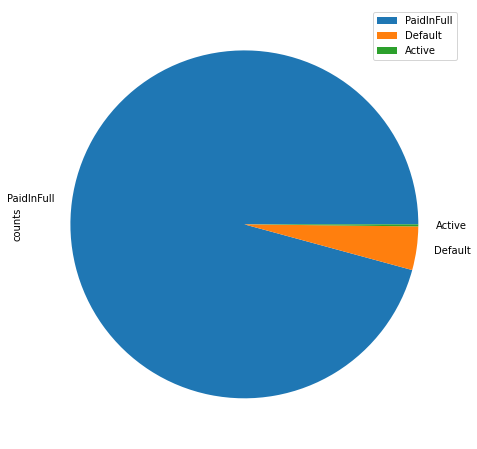

In [67]:
plot_pct(contract_status_df)

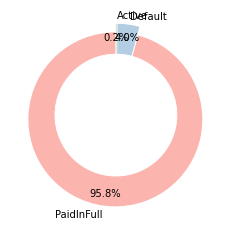

In [68]:
plot_donut(contract_status_df)

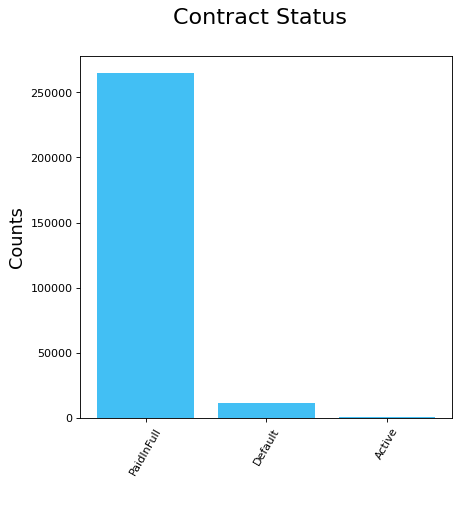

In [69]:
draw_basic_bar_plot(
    contract_status_df.index.to_list(),
    contract_status_df['counts'].to_list(),
    6, 6,
    "Contract Status", " ", "Counts"
)

In [70]:
contract_status_df

,counts
type,
PaidInFull,264847
Default,11178
Active,521


In [71]:
n = contract_status_df[contract_status_df['counts'] < 100000].sum()
contract_status_df.drop(['Default', 'Active'], inplace = True)
contract_status_df.loc['Other types'] = [n]
contract_status_df

,counts
type,
PaidInFull,264847
Other types,counts 11699 dtype: int64


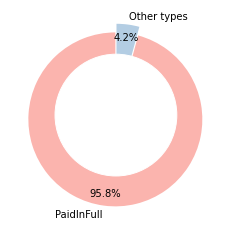

In [72]:
plot_donut(contract_status_df)

## 3.7 StartHalf

What are the percentages for each “StartHalf”

In [0]:
start_half_df = count_types('StartHalf')

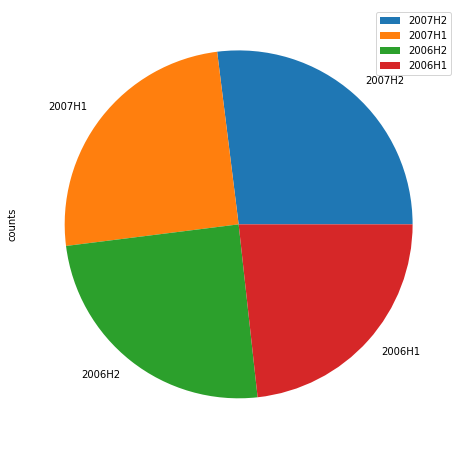

In [74]:
plot_pct(start_half_df)

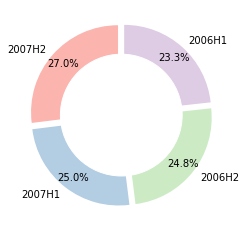

In [75]:
plot_donut(start_half_df)

## 3.8 First Installment Date

What are the number and percentages of “First Installment Date" for each month?

In [76]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,has_arrears,age,entry_y,entry_y_m,app_y,app_y_m
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,0.755885,0.2219,576.93,0.0,0.0,0.0,0.221896,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,0,45.928767,2006,2006-01,2006,2006-10


In [0]:
# put Year and Month into new columns
df['install_y_m'] = df['Fist Installment Date'].dt.to_period('M')

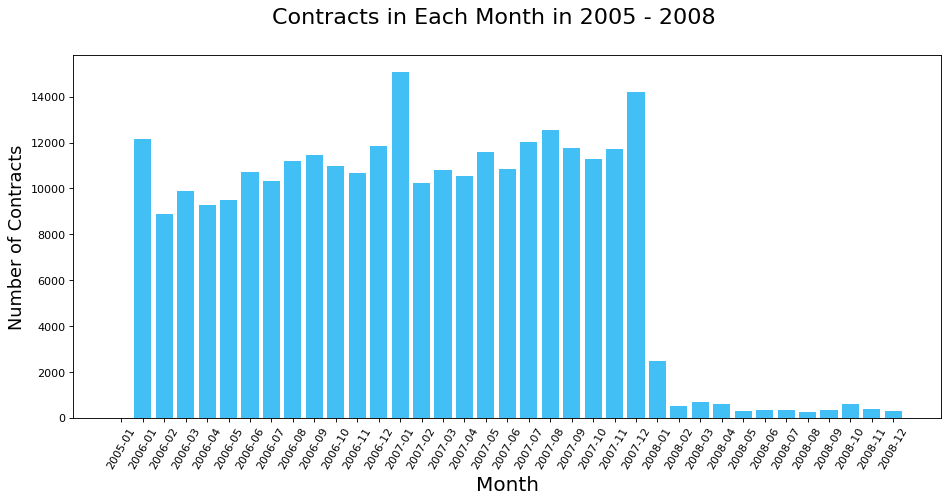

In [78]:
x, y, r = get_agg_df('install_y_m', 'Contract_Number', "count")
draw_basic_bar_plot(x, y, 14, 6, 'Contracts in Each Month in 2005 - 2008', 'Month', 'Number of Contracts')

## 3.15 Payment Type

What are the types in “payment Types”, and what are the percentages for each “payment type”?

In [0]:
pay_df = count_types('payment_type')

In [0]:
pay_df['type'] = ['Bank', 'CC']
pay_df.set_index('type', inplace = True)

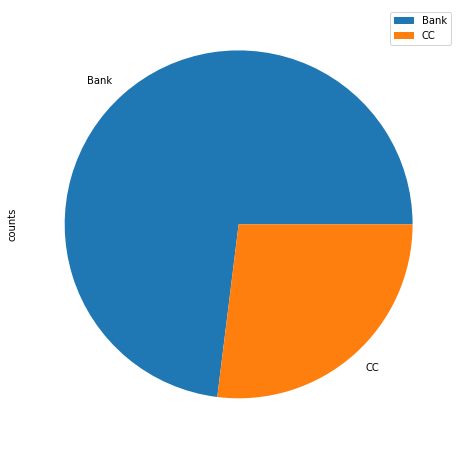

In [81]:
plot_pct(pay_df)

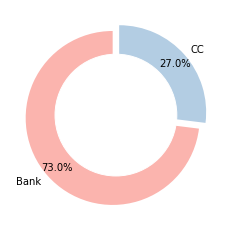

In [82]:
plot_donut(pay_df)

## 3.9 Purchased Amount

Purchase amt segments? $100-500, $500-1000, $ 1500-2000,….And percentages of each segments?

In [0]:
def explore_amt(col):
  print(f"The largest {col} was {df[col].max():,} and the least was {df[col].min()}.")

  sns.kdeplot(df[col], shade=True)

The largest Purchase Amt was 54,052.0 and the least was 70.0.


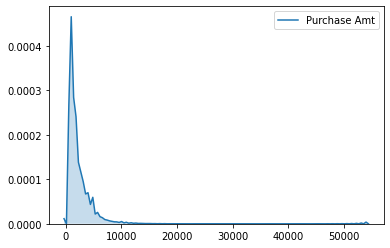

In [84]:
explore_amt('Purchase Amt')

In [0]:
def explore_amt_range(col, amt):
  sns.kdeplot(df[df[col]<amt][col], shade=True)

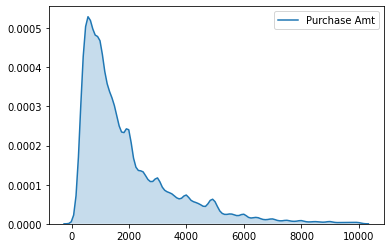

In [86]:
explore_amt_range('Purchase Amt',10000)

In [0]:
def get_segments_df(col, end, step):

  # get value counts of target column
  amt_df = df[col].value_counts()

  # put the counts into df
  amt_df = amt_df.rename_axis(col).reset_index(name='counts')

  # build a new df to store segements and counts
  amt_df_new = pd.DataFrame(columns = ['counts'])

  # set segments
  segments = range(0, end + 1, step)

  for i in segments:
    if i != 0:
      amt_df_temporary = amt_df[(amt_df[col] < i) & (amt_df[col] >= i - step )]
      k = amt_df_temporary['counts'].sum()
      word = f'{i - step} (included) to {i}'
      amt_df_new.loc[word] = k # segments as index

  # add the last row to df
  amt_df_new.loc[f'Equals to or more than {i}'] = amt_df[amt_df[col] >= end].sum()

  return amt_df_new


In [0]:
purchase_amt_df = get_segments_df('Purchase Amt', 6000, 2000)

In [0]:
#get_segments_df('Purchase Amt', 10000, 2000) == df.shape[0]

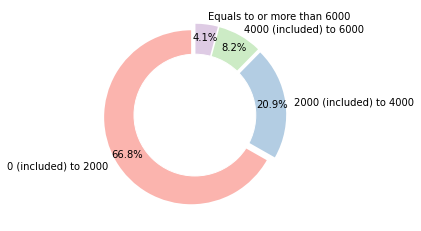

In [90]:
plot_donut(purchase_amt_df)

## 3.10 Financed amt 

Financed amt segments? And percentages of each segments?

The largest financed_amt was 15,000.0 and the least was 50.0.


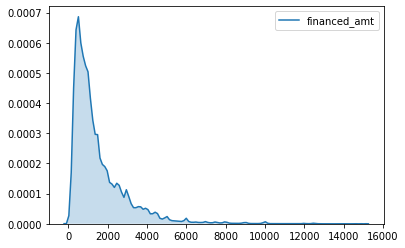

In [91]:
explore_amt('financed_amt')

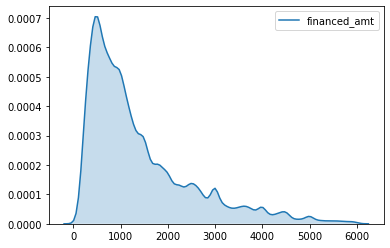

In [92]:
explore_amt_range('financed_amt', 6000)

In [0]:
financed_amt_df = get_segments_df('financed_amt', 4000, 1000)

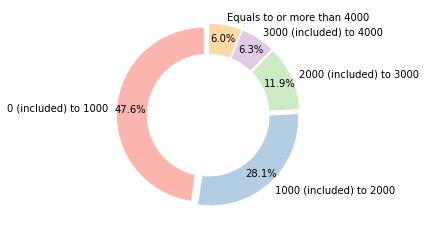

In [94]:
plot_donut(financed_amt_df)

## 3.11 Total Term


The largest Total Term was 48 and the least was 2.


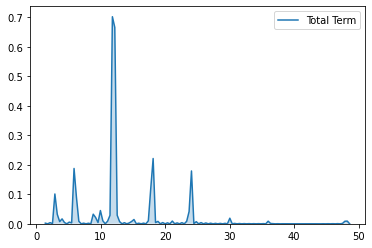

In [95]:
explore_amt('Total Term')

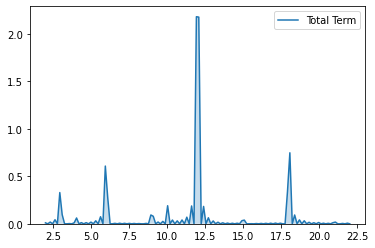

In [96]:
explore_amt_range("Total Term", 24)

In [0]:
term_df = get_segments_df('Total Term', 24, 8)

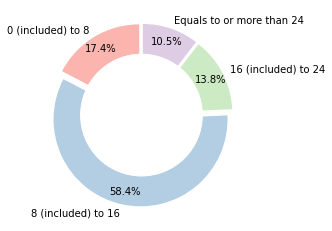

In [98]:
plot_donut(term_df)

## 3.12 Deposit_precent

The largest deposit_percent was 0.9697812 and the least was 0.0.


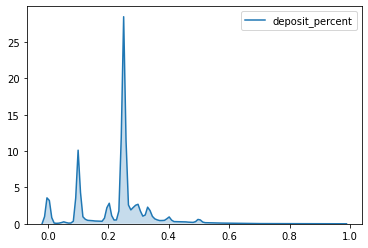

In [99]:
explore_amt('deposit_percent')

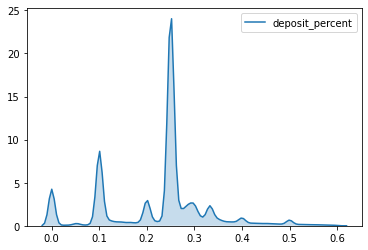

In [100]:
explore_amt_range('deposit_percent', 0.6)

In [0]:
def get_pct_segments_df(col, end, step):

  # get value counts of target column
  amt_df = df[col].value_counts()

  # put the counts into df
  amt_df = amt_df.rename_axis(col).reset_index(name='counts')

  # build a new df to store segements and counts
  amt_df_new = pd.DataFrame(columns = ['counts'])

  # set segments
  segments = range(0, int(end*100 + 1), int(step*100))  # the only difference with get_segments_df

  for i in segments:
    if i != 0:
      m = i/100
      amt_df_temporary = amt_df[(amt_df[col] < m) & (amt_df[col] >= m - step )]
      k = amt_df_temporary['counts'].sum()
      word = f'{round(m - step, 1)} (included) to {m}'
      amt_df_new.loc[word] = k # segments as index

  # add the last row to df
  amt_df_new.loc[f'Equals to or more than {m}'] = amt_df[amt_df[col] >= end].sum()

  return amt_df_new


In [0]:
deposit_percent_df = get_pct_segments_df('deposit_percent', 0.4, 0.2)

In [103]:

for i in range(0, int(0.6*100 + 1), int(0.2*100)):
  print(i)

0
20
40
60


In [104]:
deposit_percent_df

,counts
0.0 (included) to 0.2,73515
0.2 (included) to 0.4,185930
Equals to or more than 0.4,17101


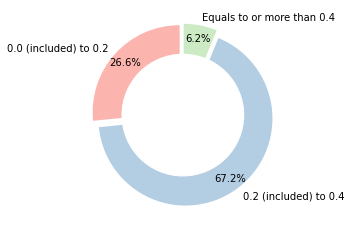

In [105]:
plot_donut(deposit_percent_df)

## 3.13 Term_Run

The largest Term_Run was 48 and the least was 2.


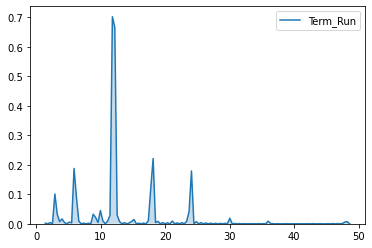

In [106]:
explore_amt('Term_Run')

In [0]:
Term_Run_df = get_segments_df('Term_Run', 24, 8)

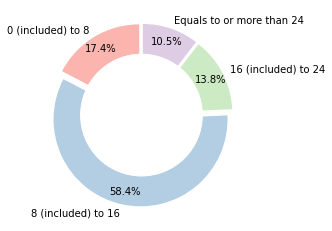

In [108]:
plot_donut(Term_Run_df)

## 3.14 Term_Remaining

The largest Term_Remaining was 10 and the least was 0.


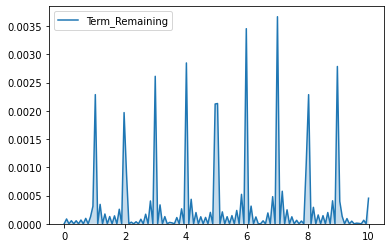

In [109]:
explore_amt('Term_Remaining')

In [0]:
Term_Remaining_df = get_segments_df('Term_Remaining', 2, 2)

In [111]:
Term_Remaining_df

,counts
0 (included) to 2,276074
Equals to or more than 2,472


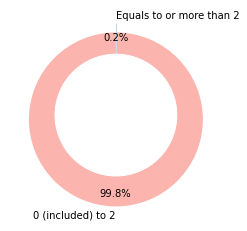

In [112]:
plot_donut(Term_Remaining_df)

In [113]:
df['Term_Remaining'].value_counts()

0     276025
5         80
8         63
6         62
9         60
7         56
2         54
4         51
1         49
3         40
10         6
Name: Term_Remaining, dtype: int64

# Step 4. Correlation

## Correlation

In [0]:
df = df_cleaned.copy()

In [0]:
features = ['financed_amt',      #贷款金额
            'deposit_percent',   #首付比例
            'payment_type',      #还款方式
            'Freq',              #还款频率
            'gst_p',             #GST和商家手续费费率 （占贷款金额的比例，以下同）
            'gtee_p',            #银行担保费率
            'est_fee_p',         #开户费率
            'other_fee_p',       #其他费用费率
            #'total_merchant_charge_p',   #以上各种费率总和
            'total_consumer_charges',    #客户所付费用费率
            #'effective_billing_rate',    #全部费率之和
            #'days_default',	     #
            #'arrear_p',          #应还金额所占比例
            #'days_arrears',	    
            #'default_p',         #初始逾期金额所占比例
            #'mth_to_default',
            'recent_default_default_p',  #最近一次逾期金额所占比例          
            #'recent_default_recov_p',    #最近一次还款金额所占比例
            'age'                #年龄
]

In [0]:
df_cor = df[features]

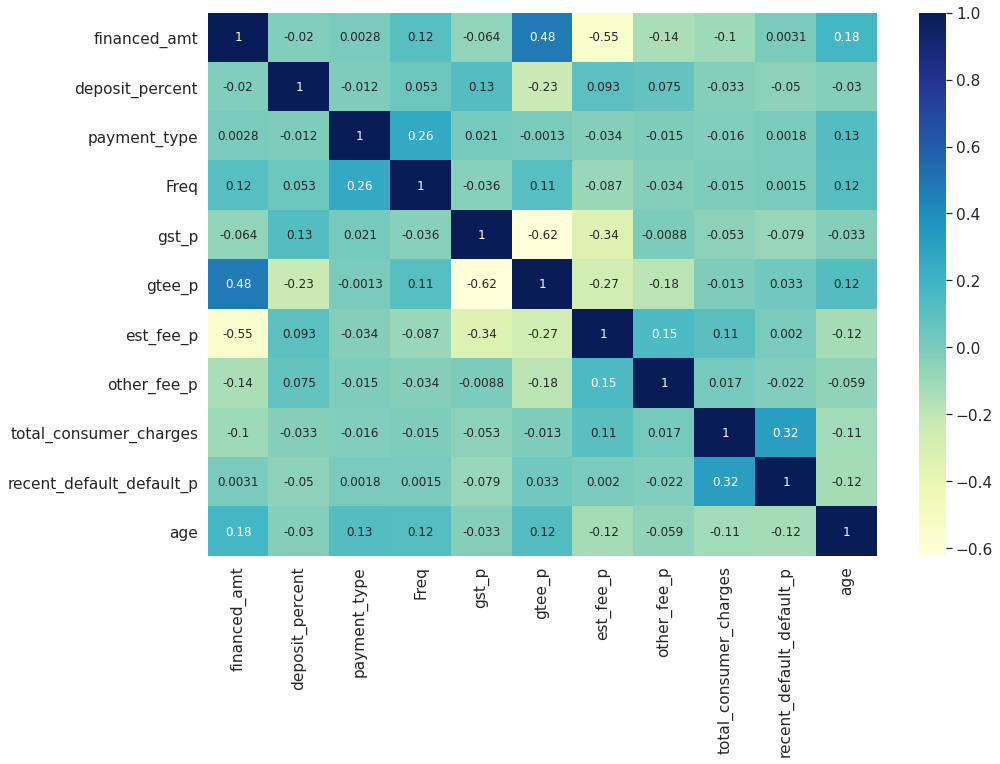

In [117]:
sns.set(font_scale=1.4) #坐标轴字号
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(df_cor.corr(), annot=True, cmap="YlGnBu", ax=ax, annot_kws={"size": 12});  #方格中字号

In [118]:
df.head(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,Proc Fees,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,No of Days in Arrears,default_p,recent_default_default_p,recent_default_recov_p,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,has_arrears,age
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.00,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.00,0.755885,0.2219,576.93,0.0,0.0,0.0,0.221896,0.000000,576.93,0.221896,2010-11-26,0,0.000000,0.0,0.000000,0.000000,0.0,,6530,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,0,45.928767
1,2,30000035,L30000035,ALARM,PaidInFull,2006-04-09,2006-09-13,2006H2,2006-09-20,3098.38,498.38,2600.00,48,0.160852,48,0,0,48,1,54.166667,2600.0,0.00,0.755885,0.2219,576.93,0.0,0.0,0.0,0.221896,0.011538,606.93,0.233435,2010-09-20,0,0.000000,0.0,0.000000,0.000000,0.0,,6065,1944-10-31,30112641,MODERN SECURITY WA,Home Security,1,1,0,61.479452
2,3,30000051,L30000051,ALARM,Default,2006-09-15,2006-09-27,2006H2,2006-05-10,2632.38,1000.00,1632.38,48,0.379884,48,0,0,48,1,34.007917,1496.0,136.38,0.755890,0.2219,362.22,0.0,0.0,0.0,0.221897,0.000000,362.22,0.221897,2010-05-10,277,0.083547,277.0,0.083547,0.083547,0.0,,6157,1919-04-18,30112641,MODERN SECURITY WA,Home Security,1,1,1,87.471233


## Categorical Variables

In [0]:
# get product types (bought more than 1000 times)
product_types = product_df_new.index.to_list()

In [0]:
# build a new empty df

product_arrears_df = pd.DataFrame(index = product_types, 
                                  columns = ['no_arrears', 'has_arrears'])
product_arrears_df = product_arrears_df.fillna(0)

In [0]:
def get_product_agg_df(types, k):
  """
  INPUT:
    k - has or no arrears (0 or 1)
  OUTPUT:
    a list of counts of various product types
  """

  values = []

  df_temp = df[df['has_arrears']==k]

  for type in types:
    new_df = df_temp.query('Product == @type')['Product'].value_counts()

    new_df = new_df.rename_axis('type').reset_index(name='counts')
    new_df.set_index('type', inplace=True)

    n = new_df.loc[type]['counts']
    values.append(n)

  return values


In [0]:
# Fill the df 
product_counts_no_arr = get_product_agg_df(product_types, 0)
product_counts_has_arr = get_product_agg_df(product_types, 1)


product_arrears_df['no_arrears'] = product_counts_no_arr
product_arrears_df['has_arrears'] = product_counts_has_arr

In [0]:
def plot_compare_bar(x1, x2, xlabel):
  """
  x1, x2 - list of values
  xlabel - list of type names
  """

  data = [x1, x2]

  X = np.arange(len(xlabel))

  plt.figure(figsize=(16, 6))

  plt.bar(X + 0.0, data[0], color = my_color[0], width = 0.5)
  plt.bar(X + 0.5, data[1], color = my_color[1], width = 0.5)

  plt.xticks(X+0.25, xlabel, rotation = 90)

  plt.show()


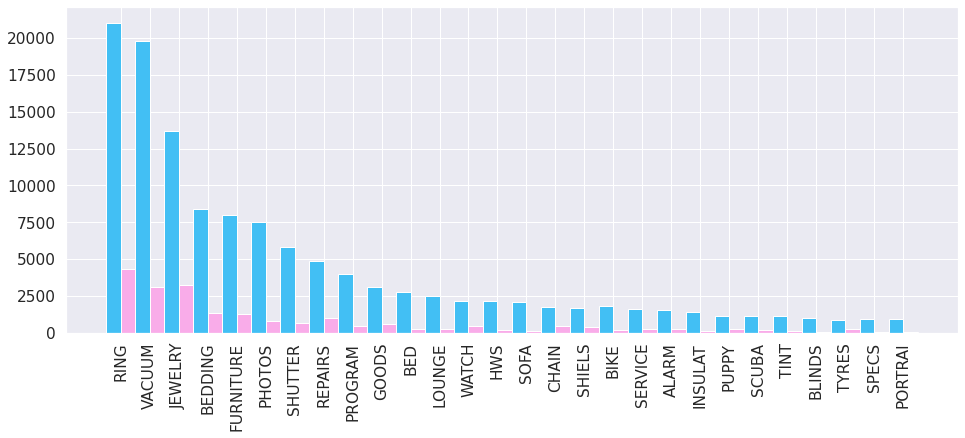

In [220]:
plot_compare_bar(product_counts_no_arr, product_counts_has_arr, product_types)